### Customer Model with varying training period
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import lightgbm as lgb
import src.monitoring.utils as mu
import src.monitoring.monitoring as mntr
import rdsutils.score_alignment as sa
import src.monitoring.refit as refit

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

### Data
---

<AxesSubplot:>

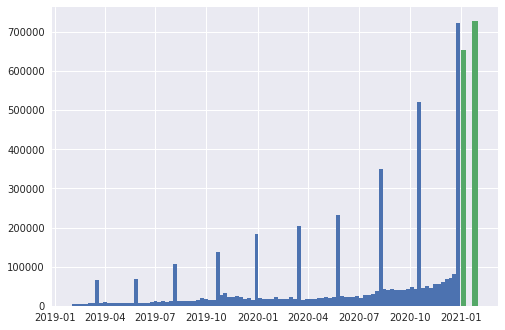

In [2]:
mmonth = "202104"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"
train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_scored.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_scored.parquet"))

train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=3)

In [3]:
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.919963
        True             0.042799
True    False            0.003103
        True             0.034135
dtype: float64

In [4]:
train_df = mu.preprocess(train_df)
test_df = mu.preprocess(test_df)

In [5]:
train_df.shape, test_df.shape

((4657017, 95), (1381389, 106))

In [6]:
s_df = train_df[train_df.is_static]
d_df = train_df[~train_df.is_static]

In [7]:
# static

df = s_df
df["indeterminate_prev"] = (  # why is it defined like this?
            (df["nr_transactions_next_60d"] == 0)
            | (pd.to_datetime(df["dtc"]) <= df["sample_date"])
            | (df["last_unrestricted_date"] <= df["sample_date"])
            | (df["chg_wrt_off_date"] <= df["sample_date"])
            | (df["target"] & (df["latest_acc_bal"] > 0))
            | (
                ~df["target"] & (~df["chg_wrt_off_date"].isna())
                | (df["latest_acc_bal"] < 0)
                | (
                    df["closed_reason"].isin(
                        [
                            "Closed by SoFi - Risk Request",
                            "Closed by SoFi - Charge-Off / Write-Off",
                        ]
                    )
                )
                | (df["restricted_reason"].str.startswith("No"))
            )
        )

In [8]:
# dynamic

df = d_df


transaction_codes_to_sample_on = [
        "POSDW",
        "ACHDWIN",
        "ACHDDIN",
        "ACHDD",
        "ACHINDD",
        "DDATMREFUND",
        "DWATM",
        "ACHDW",
        "DWCRDBILLPAY",
        "DDCK",
        "DDCRDBILLREF",
        "DWTRF",
        "DWCK",
        "DWBILLPAY",
        "DDA2ATXFR",
        "DDRAFNEW",
        "DDRAFCUS",
        "DDTRF",
        "POSDD",
        "DDMBR",
        "DWMBR",
        "DWATMI",
        "DDLYFTBONUS",
        "DDMKT",
        "DPNC",
        "DPND",
        "OTID",
        "ACHDWP2P",
        "DW",
        "DDINT",
        "DD",
        "DWACHRET",
        "DDPC",
        "DWSLROTP",
        "DWCKCB",
        "DDBILLPAY",
        "ACHRD",
        "DDACHRET",
    ]

df["indeterminate_prev"] = ((df["target"] & (df["latest_acc_bal"] > 0)) | (
            ~df["target"] & ((~df["chg_wrt_off_date"].isna())
            | (df["latest_acc_bal"] < 0)
            | (
                df["closed_reason"].isin(
                    [
                        "Closed by SoFi - Risk Request",
                        "Closed by SoFi - Charge-Off / Write-Off",
                    ]
                )
            )
            | (df["restricted_reason"].str.startswith("No"))
            | (df["bal_after_90d"] == 0)))
    | df["transaction_code"].isin(transaction_codes_to_sample_on)
        )


In [9]:
train_df = pd.concat([s_df, d_df])
train_df.shape

(4657017, 96)

In [10]:
train_df[["target", "indeterminate"]].value_counts(normalize=True).sort_index()

target  indeterminate
False   False            0.919963
        True             0.042799
True    False            0.003103
        True             0.034135
dtype: float64

In [11]:
train_df[["target", "indeterminate_prev"]].value_counts(normalize=True).sort_index()

target  indeterminate_prev
False   False                 0.152459
        True                  0.810303
True    False                 0.000820
        True                  0.036418
dtype: float64

### Model Fitting Modeles
---

In [12]:
static_sample_dates = sorted(train_df[train_df.is_static].sample_date.unique())
static_sample_dates = [d for d in static_sample_dates if d >= pd.to_datetime("2020-01-01")]
static_sample_dates

[numpy.datetime64('2020-01-01T00:00:00.000000000'),
 numpy.datetime64('2020-03-14T00:00:00.000000000'),
 numpy.datetime64('2020-05-26T00:00:00.000000000'),
 numpy.datetime64('2020-08-07T00:00:00.000000000'),
 numpy.datetime64('2020-10-19T00:00:00.000000000'),
 numpy.datetime64('2020-12-31T00:00:00.000000000')]

In [13]:
%%time

clfs = {}

for d in tqdm(static_sample_dates):
    dt_str = str(d).split("T")[0]
    train_df_ = train_df[train_df.sample_date <= d]
        
    for ind in [None, "indeterminate", "indeterminate_prev"]:

        clf = refit.train(train_df_, 
                        date_col="sample_date",
                        indeterminate_col=ind)
        
        if ind is None:
            ind_str = "w_ind"
        elif ind == "indeterminate":
            ind_str = "wo_ind"
        elif ind == "indeterminate_prev":
            ind_str = "wo_prev_ind"
        else:
            raise NotImplemented

        clf_name = f"model_{dt_str}_{ind_str}"
        pred_col = f"pred_{dt_str}_{ind_str}"
        score_col = f"score_{dt_str}_{ind_str}"
        test_df[pred_col] = clf.predict_proba(test_df[clf.feature_name_])[:,1]
#         test_df[score_col] = mu.scale_scores(test_df[pred_col])
        
        # rescale by bad rates
#         src_pred = pred_col
#         tgt_pred = "pred_incumbent"
#         target_col = "target"
#         br_tbl = sa.get_score_alignment_table(test_df, src_pred, tgt_pred, target_col,
#                                            br_precision = 3, pred_precision = 3)
#         test_df[pred_col+"_rescaled"] = sa.get_aligned_score(test_df, br_tbl, src_pred, tgt_pred,
#                                                             pred_precision=3)

#         test_df[score_col+"_rescaled"] = mu.scale_scores(test_df[pred_col+"_rescaled"])

        # save model
        clfs[clf_name] = clf

        

  0%|          | 0/6 [00:00<?, ?it/s]

modeling_df last date: 2020-01-01 00:00:00
15556
target counts
False    1037207
True       53397
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 17%|█▋        | 1/6 [00:57<04:47, 57.57s/it]

modeling_df last date: 2020-03-14 00:00:00
15556
target counts
False    1408652
True       64686
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 33%|███▎      | 2/6 [02:01<04:04, 61.17s/it]

modeling_df last date: 2020-05-26 00:00:00
15556
target counts
False    1804959
True       75847
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 50%|█████     | 3/6 [03:09<03:12, 64.21s/it]

modeling_df last date: 2020-08-07 00:00:00
15556
target counts
False    2362271
True       96494
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 67%|██████▋   | 4/6 [04:32<02:23, 71.65s/it]

modeling_df last date: 2020-10-19 00:00:00
15556
target counts
False    3248548
True      128994
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 83%|████████▎ | 5/6 [06:14<01:22, 82.61s/it]

modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    4483599
True      173418
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

100%|██████████| 6/6 [08:25<00:00, 84.28s/it]

CPU times: user 11h 3min 1s, sys: 44.2 s, total: 11h 3min 45s
Wall time: 8min 25s


In [14]:
print(clfs)

{'model_2020-01-01_w_ind': LGBMClassifier(bagging_seed=15556, boosting='gbdt',
               categorical_feature=[39, 40, 41], feature_fraction=0.8,
               lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
               metric='auc', min_data_in_leaf=116, num_iterations=1400,
               num_leaves=15, objective='binary',
               scale_pos_weight=19.424443320785812, seed=15556, subsample=0.94,
               tree_learner='feature', verbosity=1), 'model_2020-01-01_wo_ind': LGBMClassifier(bagging_seed=15556, boosting='gbdt',
               categorical_feature=[39, 40, 41], feature_fraction=0.8,
               lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
               metric='auc', min_data_in_leaf=116, num_iterations=1400,
               num_leaves=15, objective='binary',
               scale_pos_weight=298.41297935103245, seed=15556, subsample=0.94,
               tree_learner='feature', verbosity=1), 'model_2020-01-01_wo_prev_ind': LGBMCl

### Performances
---

In [15]:
pred_cols = [c for c in test_df.columns 
             if "pred_" in c and "_rescaled" not in c]
score_cols = [c for c in test_df.columns 
              if "score_" in c and "_rescaled" not in c]

In [16]:
%%time 

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-01-01")]
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report.sort_values("ap", ascending=False))

,auc,ap,ks
pred_2020-12-31_w_ind,91.49,33.72,68.05
pred_w_ind,91.47,33.58,68.06
pred_2020-10-19_w_ind,90.21,27.28,65.88
pred_2020-08-07_w_ind,89.04,24.68,63.43
pred_2020-05-26_w_ind,87.40,23.20,59.25
pred_2020-03-14_w_ind,86.63,21.37,57.93
pred_2020-01-01_w_ind,86.12,20.05,56.88
pred_incumbent,68.61,10.01,23.48
pred_2020-12-31_wo_ind,64.73,3.78,22.46
pred_wo_ind,63.95,3.63,21.35


CPU times: user 29.7 s, sys: 2.92 s, total: 32.6 s
Wall time: 32.6 s


In [17]:
%%time 

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-02-01")]
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report.sort_values("ap", ascending=False))

,auc,ap,ks
pred_2020-12-31_w_ind,91.32,32.43,68.14
pred_w_ind,91.28,32.21,68.01
pred_2020-10-19_w_ind,90.15,26.32,65.69
pred_2020-08-07_w_ind,88.83,23.66,63.29
pred_2020-05-26_w_ind,87.15,22.35,59.27
pred_2020-03-14_w_ind,86.45,21.21,57.70
pred_2020-01-01_w_ind,86.07,20.37,56.94
pred_incumbent,67.31,10.28,21.93
pred_2020-03-14_wo_prev_ind,50.82,3.58,9.92
pred_2020-12-31_wo_ind,61.52,2.04,17.84


CPU times: user 32.6 s, sys: 3.02 s, total: 35.6 s
Wall time: 35.6 s


### Thoughts
---

Interestingly we were able to replicate the incumbent model's result here. Let's rebuild the data with the original indeterminate definition and take a look.

Looking at the numbers this worked out...? Now let's look at the scores. It doesn't make sense, as the original method should not work

In [18]:
candidate_cols = ["pred_2020-12-31_wo_prev_ind", 
                  "pred_2020-12-31_w_ind",
                  "pred_incumbent"]

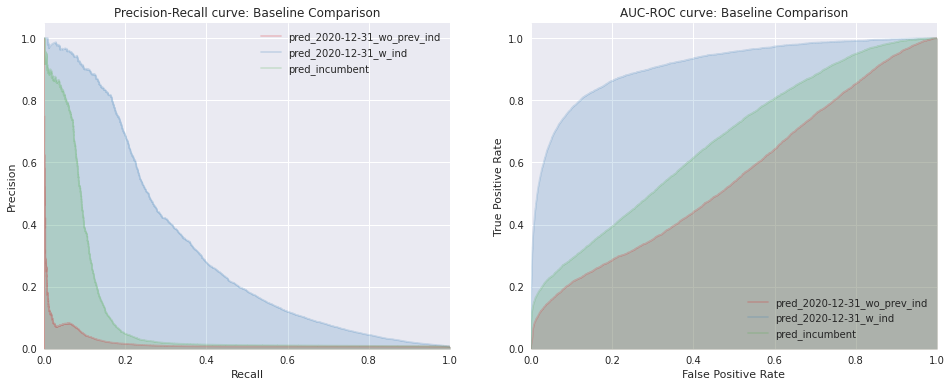

In [19]:
mntr_path = "./artifacts"
mntr.save_valid_performance_plots(
        {"reduced": df_}, "target", candidate_cols, mntr_path, dropna=True
    )

In [21]:
def plot_score_distr(df, score1, score2, ax, title):

    df[score1].hist(bins=50, alpha=0.4, label=score1, ax=ax)
    df[score2].hist(bins=50, alpha=0.4, label=score2, ax=ax)
    
    ax.set_title(title)
    ax.legend()

In [25]:
test_df["score_2020-12-31_w_ind"] = mu.scale_scores(test_df["pred_2020-12-31_w_ind"])

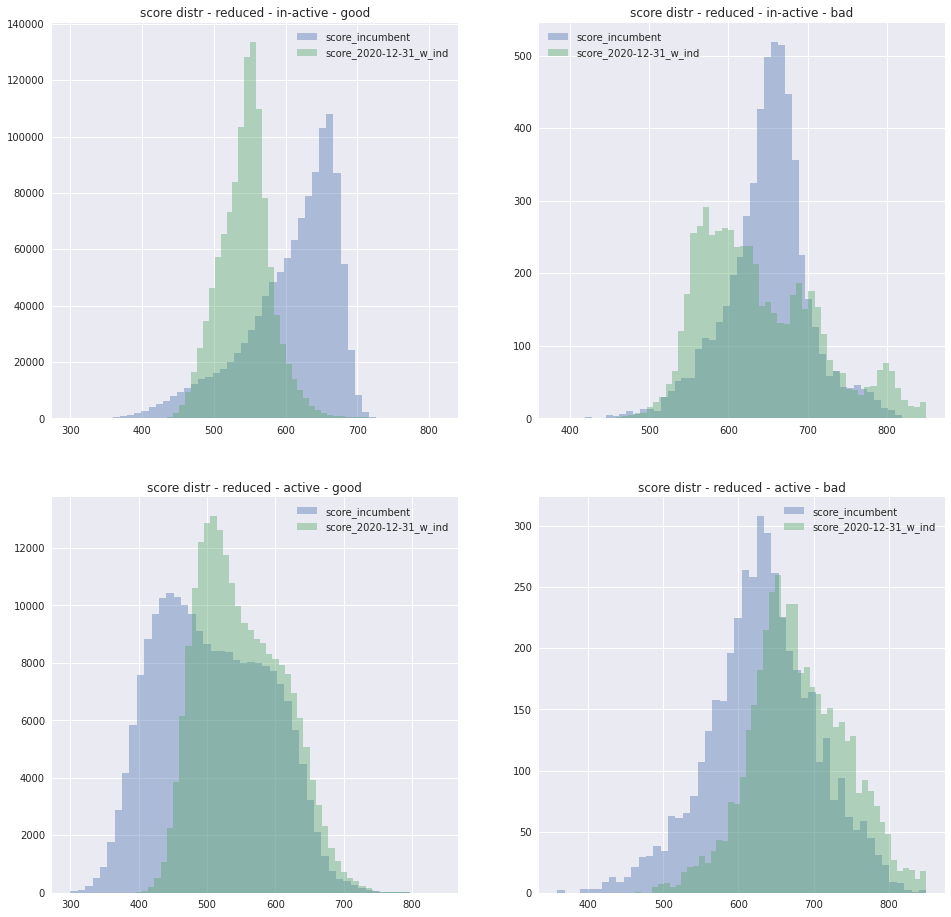

In [26]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_2020-12-31_w_ind"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, score1, score2, axs[0, 0], "score distr - reduced - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, score1, score2, axs[0, 1], "score distr - reduced - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, score1, score2, axs[1, 0], "score distr - reduced - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, score1, score2, axs[1, 1], "score distr - reduced - active - bad")

plt.show()

### Using Thomas's pipeline - replica

In [33]:
train_df = pd.read_feather("../../data/combined/combined_1620538441.feather")
train_df = mu.preprocess(train_df)

In [35]:
for d in tqdm(static_sample_dates):
    dt_str = str(d).split("T")[0]
    train_df_ = train_df[train_df.sample_date <= d]
        

    clf = refit.train(train_df_, 
                    date_col="sample_date",
                    indeterminate_col=None)

    ind_str = "prev_ind_org"

    clf_name = f"model_{dt_str}_{ind_str}"
    pred_col = f"pred_{dt_str}_{ind_str}"
    score_col = f"score_{dt_str}_{ind_str}"
    test_df[pred_col] = clf.predict_proba(test_df[clf.feature_name_])[:,1]

  0%|          | 0/6 [00:00<?, ?it/s]

modeling_df last date: 2020-01-01 00:00:00
15556
target counts
False    685288
True      51549
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored.

 17%|█▋        | 1/6 [00:16<01:21, 16.35s/it]

modeling_df last date: 2020-03-14 00:00:00
15556
target counts
False    924735
True      61764
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored.

 33%|███▎      | 2/6 [00:39<01:20, 20.19s/it]

modeling_df last date: 2020-05-26 00:00:00
15556
target counts
False    1157227
True       71004
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 50%|█████     | 3/6 [01:01<01:03, 21.17s/it]

modeling_df last date: 2020-08-07 00:00:00
15556
target counts
False    1464602
True       87335
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 67%|██████▋   | 4/6 [01:27<00:46, 23.05s/it]

modeling_df last date: 2020-10-19 00:00:00
15556
target counts
False    1930733
True      112468
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

 83%|████████▎ | 5/6 [01:59<00:26, 26.18s/it]

modeling_df last date: 2020-12-31 00:00:00
15556
target counts
False    2568532
True      140444
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

100%|██████████| 6/6 [02:38<00:00, 26.47s/it]


In [38]:
%%time 
pred_cols = [c for c in test_df.columns 
             if "pred_" in c and "_rescaled" not in c]

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-02-01")]
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report.sort_values("ap", ascending=False))

,auc,ap,ks
pred_2020-12-31_w_ind,91.32,32.43,68.14
pred_w_ind,91.28,32.21,68.01
pred_2020-10-19_w_ind,90.15,26.32,65.69
pred_2020-08-07_w_ind,88.83,23.66,63.29
pred_2020-05-26_w_ind,87.15,22.35,59.27
pred_2020-03-14_w_ind,86.45,21.21,57.70
pred_2020-01-01_w_ind,86.07,20.37,56.94
pred_2020-12-31_prev_ind_org,77.53,17.36,38.60
pred_2020-10-19_prev_ind_org,74.34,13.05,31.95
pred_2020-05-26_prev_ind_org,71.45,11.46,27.92


CPU times: user 42 s, sys: 3.84 s, total: 45.9 s
Wall time: 45.9 s


In [40]:
%%time 
pred_cols = [c for c in test_df.columns 
             if "prev_ind_org" in c] + ["pred_incumbent"]

df_ = test_df[test_df.sample_date == pd.to_datetime("2021-02-01")]
report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
display(report.sort_values("ap", ascending=False))

,auc,ap,ks
pred_2020-12-31_prev_ind_org,77.53,17.36,38.60
pred_2020-10-19_prev_ind_org,74.34,13.05,31.95
pred_2020-05-26_prev_ind_org,71.45,11.46,27.92
pred_2020-08-07_prev_ind_org,73.00,11.37,30.35
pred_2020-03-14_prev_ind_org,71.08,10.58,27.08
pred_incumbent,67.31,10.28,21.93
pred_2020-01-01_prev_ind_org,69.59,8.27,24.98


CPU times: user 11.1 s, sys: 1.04 s, total: 12.1 s
Wall time: 12.1 s


In [46]:
test_df["score_2020-12-31_prev_ind_org"] = mu.scale_scores(test_df["pred_2020-12-31_prev_ind_org"])

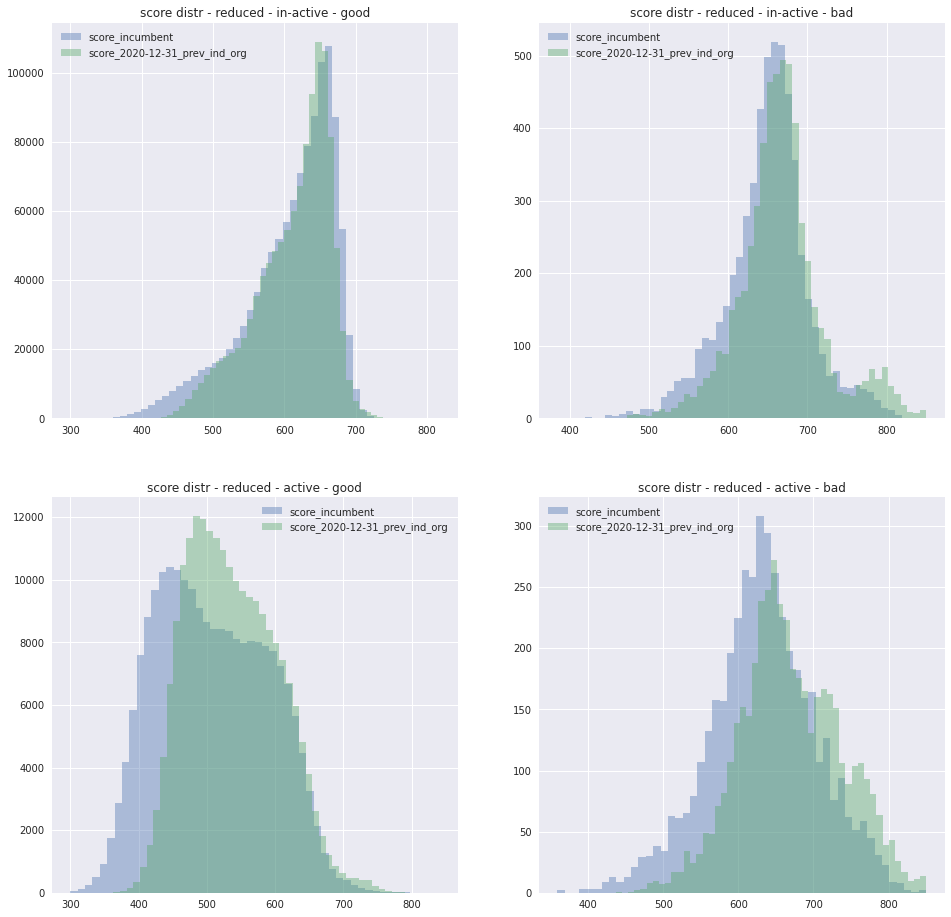

In [42]:
# plot 4x4
score1 = "score_incumbent"
score2 = "score_2020-12-31_prev_ind_org"

fig, axs = plt.subplots(2,2, figsize=(16, 16))

df_ = test_df[~test_df.is_active & ~test_df.target]  # inactive good accounts
plot_score_distr(df_, score1, score2, axs[0, 0], "score distr - reduced - in-active - good")

df_ = test_df[~test_df.is_active & test_df.target]  # inactive bad accounts
plot_score_distr(df_, score1, score2, axs[0, 1], "score distr - reduced - in-active - bad")

df_ = test_df[test_df.is_active & ~test_df.target]  # active good accounts
plot_score_distr(df_, score1, score2, axs[1, 0], "score distr - reduced - active - good")

df_ = test_df[test_df.is_active & test_df.target]  # active bad accounts
plot_score_distr(df_, score1, score2, axs[1, 1], "score distr - reduced - active - bad")

plt.show()

<AxesSubplot:>

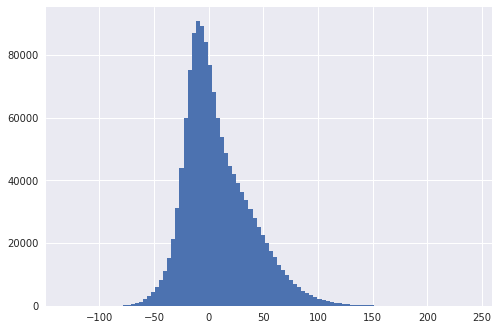

In [53]:
(test_df["score_2020-12-31_prev_ind_org"] - test_df["score_incumbent"]).hist(bins=100)

In [47]:
# okay it appears we may have found a way! Let's formalize the pipeline later
# here just plot the risk groups

def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

test_df["rg_incumbent"] = get_risk_groups(test_df.score_incumbent)
test_df["rg_2020-12-31_prev_ind_org"] = get_risk_groups(test_df["score_2020-12-31_prev_ind_org"])


Text(0.5, 1.0, 'Risk Group Shift')

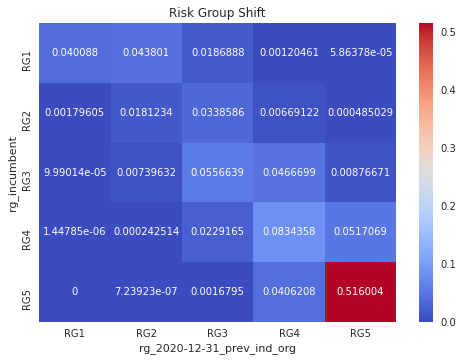

In [49]:
# look at risk groups
rg_incumbent = "rg_incumbent"
rg_refit = "rg_2020-12-31_prev_ind_org"
table = test_df[[rg_incumbent, rg_refit]].value_counts(normalize=True).sort_index().reset_index()
table.columns = [rg_incumbent, rg_refit, 'counts']
table = pd.pivot_table(table, values='counts', index=rg_incumbent, 
                       columns=rg_refit, fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift')


In [50]:
print("ratio of users kept their RG: ", np.trace(table))

ratio of users kept their RG:  0.7133148298563303


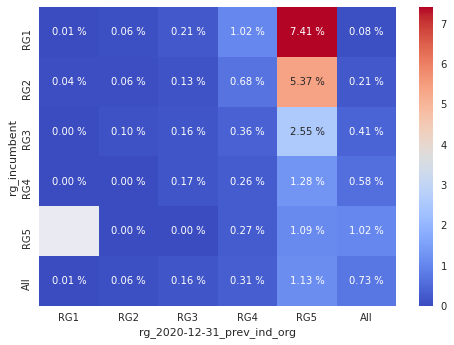

In [54]:
import rdsutils.swap_set_analysis as ssa
fig, ax = ssa.plot_swap_set_bad_rate(test_df, rg_incumbent, rg_refit, "target", margins=True)

This is good. This means the new model is able to capture RG5s that are misclassified as RG1 in the incumbent model